In [1]:
import torch
import torchvision

C:\Users\endo\anaconda3\envs\yolov7_custon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.11.0+cu113
0.12.0+cu113


In [3]:
# import matplotlib
# matplotlib.use('TkAgg')

In [4]:
import matplotlib.pyplot as plt

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys

sys.path.append('..')
sys.path.append('../examples')

# Data Loading

First, let's take a look at how to load our dataset in the format that Yolov7 expects.

## Selecting a dataset

Throughout this article, we shall use the [Kaggle cars object detection dataset](https://www.kaggle.com/datasets/sshikamaru/car-object-detection); however, as our aim is to demonstrate how Yolov7 can be applied to any problem, this is really the least important part of this work. Additionally, as the images are quite similar to COCO, it will enable us to experiment with a pretrained model before we do any training.


In [7]:
from pathlib import Path
import os
import pandas as pd

In [8]:
data_path = "../data/papilla"
data_path = Path(data_path)
images_path = data_path / "all_images"
annotations_file_path = data_path / "annotations_final.csv"

The annotations for this dataset are in the form of a .csv file, which associates the image name with the corresponding annotations; where each row represents one bounding box. Whilst there are around 1000 images in the training set, only those with annotations are included in this file. 

We can view the format of this by loading it into a pandas DataFrame. 

In [9]:
df= pd.read_csv(annotations_file_path).drop(columns='Unnamed: 0')

In [10]:
df

,image,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
0,0104G2021-03-24-15h05m37s184.png,634.0,173.0,1068.0,576.0,papilla,True,226272,0.0
1,0104G2021-03-24-15h05m38s864.png,616.0,177.0,1068.0,580.0,papilla,True,226273,0.0
2,0104G2021-03-24-15h05m33s582.png,689.0,131.0,1107.0,494.0,papilla,True,226274,0.0
3,0104G2021-03-24-15h05m35s099.png,718.0,120.0,1056.0,481.0,papilla,True,226275,0.0
4,0104G2021-03-24-15h05m32s249.png,703.0,126.0,1122.0,497.0,papilla,True,226276,0.0
...,...,...,...,...,...,...,...,...,...
1034,00953G00827.png,801.0,76.0,1119.0,324.0,papilla,True,227100,0.0
1035,00953G00822.png,601.0,59.0,1025.0,318.0,papilla,True,227101,0.0
1036,00953G00829.png,856.0,102.0,1118.0,298.0,papilla,True,227102,0.0
1037,00953G00819.png,649.0,58.0,1024.0,244.0,papilla,True,227104,0.0


As it is not usually the case that all images in our dataset contain instances of the objects that we are trying to detect, we would also like to include some images that do not contain cars. To do this, we can define a function to load the annotations which also includes 100 'negative' images. Additionally, as the designated test set is unlabelled, let's randomly take 20% of these images to use as our validation set. 

In [11]:
import pandas as pd
import random

def load_cars_df(annotations_file_path, images_path):
    # all_images = sorted(set([p.parts[-1] for p in images_path.iterdir()]))
    image_id_to_image = {i: im for i, im in zip(df.image_id, df.image)}
    image_to_image_id = {v: k for k, v, in image_id_to_image.items()}
    
    class_id_to_label = dict(
        enumerate(df.query("has_annotation == True").class_name.unique())
    )
    class_label_to_id = {v: k for k, v in class_id_to_label.items()}

    from sklearn.model_selection import train_test_split
    # first, split into X_train, X_valid_test, y_train, y_valid_test
    # `test_size=0.3` split into 70% and 30%
    train_df, valid_test_df = train_test_split(df, test_size=0.3, random_state=42)

    # second, split into X_valid, X_test, y_valid, y_test
    # `test_size=0.5` split into 50% and 50%. The original data set is 30%,
    # so, it will split into 15% equally.
    valid_df, test_df = train_test_split(valid_test_df, test_size=0.5, random_state=42)


    
    lookups = {
        "image_id_to_image": image_id_to_image,
        "image_to_image_id": image_to_image_id,
        "class_id_to_label": class_id_to_label,
        "class_label_to_id": class_label_to_id,
    }
    return train_df, valid_df, test_df, lookups

We can now use this function to load our data:

In [12]:
train_df, valid_df, test_df, lookups = load_cars_df(annotations_file_path, images_path)

In [13]:
train_df.head()

,image,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
118,0104G2021-03-24-15h10m49s388.png,561.0,320.0,900.0,581.0,papilla,True,226389,0.0
914,00953G00709.png,701.0,105.0,1004.0,564.0,papilla,True,226984,0.0
250,0104G09661.png,580.0,48.0,1112.0,526.0,papilla,True,226522,0.0
390,0305G2021-03-24-15h22m13s740.png,551.0,262.0,1118.0,680.0,papilla,True,226662,0.0
827,00011.jpg,NaN,NaN,NaN,NaN,background,False,243877,NaN


In [14]:
valid_df.head()

,image,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
760,0104G2021-03-24-14h59m28s244.png,768.0,154.0,978.0,532.0,papilla,True,227236,0.0
139,0104G2021-03-24-15h12m07s678.png,772.0,41.0,979.0,271.0,papilla,True,226411,0.0
688,0104G2021-03-24-14h55m23s665.png,642.0,189.0,920.0,457.0,papilla,True,227164,0.0
1004,00953G00795.png,NaN,NaN,NaN,NaN,background,False,227070,NaN
538,0305G2021-03-24-15h35m27s941.png,604.0,44.0,1120.0,336.0,papilla,True,226810,0.0


In [15]:
test_df.head()

,image,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
485,0305G2021-03-24-15h30m45s167.png,NaN,NaN,NaN,NaN,background,False,226757,NaN
1034,00953G00827.png,801.0,76.0,1119.0,324.0,papilla,True,227100,0.0
643,0104G2021-03-24-14h53m26s950.png,705.0,456.0,983.0,630.0,papilla,True,227119,0.0
665,0104G2021-03-24-14h54m21s113.png,624.0,160.0,1073.0,541.0,papilla,True,227141,0.0
1036,00953G00829.png,856.0,102.0,1118.0,298.0,papilla,True,227102,0.0


In [16]:
print(train_df.image.nunique(), valid_df.image.nunique(), test_df.image.nunique())

727 156 156


In [17]:
# Splitting Validation into Val and Test

To make it easier to associate predictions with an image, we have assigned each image a unique id; in this case it is just an incrementing integer count. Additionally, we have added an integer value to represent the classes that we want to detect, which is a single class - 'car' - in this case.

Generally, object detection models reserve `0` as the background class, so class labels should start from `1`. This is **not** the case for Yolov7, so we start our class encoding from `0`. For images that do not contain a car, we do not require a class id. We can confirm that this is the case by inspecting the lookups returned by our function.

In [18]:
lookups.keys()

dict_keys(['image_id_to_image', 'image_to_image_id', 'class_id_to_label', 'class_label_to_id'])

In [19]:
lookups['class_label_to_id'], lookups['class_id_to_label']

({'papilla': 0}, {0: 'papilla'})

Finally, let's see the number of images in each class for our training and validation sets. As an image can have multiple annotations, we need to make sure that we account for this when calculating our counts:

In [20]:
print(f"Num. annotated images in training set: {len(train_df.query('has_annotation == True').image.unique())}")
print(f"Num. Background images in training set: {len(train_df.query('has_annotation == False').image.unique())}")
print(f"Total Num. images in training set: {len(train_df.image.unique())}")
print('------------')

print(f"Num. annotated images in validation set: {len(valid_df.query('has_annotation == True').image.unique())}")
print(f"Num. Background images in validation set: {len(valid_df.query('has_annotation == False').image.unique())}")
print(f"Total Num. images in validation set: {len(valid_df.image.unique())}")

Num. annotated images in training set: 662
Num. Background images in training set: 65
Total Num. images in training set: 727
------------
Num. annotated images in validation set: 138
Num. Background images in validation set: 18
Total Num. images in validation set: 156


## Create a Dataset Adaptor

Usually, at this point, we would create a PyTorch dataset specific to the model that we shall be training. 

However, we often use the pattern of first creating a dataset 'adaptor' class, with the sole responsibility of wrapping the underlying data sources and loading this appropriately. This way, we can easily switch out adaptors when using different datasets, without changing any pre-processing logic which is specific to the model that we are training.

Therefore, let’s focus for now on creating a `CarsDatasetAdaptor` class, which converts the specific raw dataset format into an image and corresponding annotations. Additionally, let's load the image id that we assigned, as well as the height and width of our image, as they may be useful to us later on.

An implementation of this is presented below:

In [21]:
from train_cars import CarsDatasetAdaptor

INFO:pytorch_accelerated:Setting random seeds


Notice that, for our background images, we are just returning an empty array for our bounding boxes and class ids.

Using this, we can confirm that the length of our dataset is the same as the total number of training images that we calculated earlier.

In [22]:
train_ds = CarsDatasetAdaptor(images_path, train_df)
valid_ds= CarsDatasetAdaptor(images_path, valid_df)
test_ds= CarsDatasetAdaptor(images_path, test_df)

In [23]:
train_ds

Now, we can use this to visualise some of our images, as demonstrated below.

In [24]:
from yolov7.plotting import show_image

Let's wrap our data adaptor using this dataset and inspect some of the outputs:

### Transforms

In [25]:
from yolov7.dataset import Yolov7Dataset
from yolov7.dataset import create_yolov7_transforms

In [26]:
target_image_size = 640

In [27]:
train_yds = Yolov7Dataset(train_ds, transforms=create_yolov7_transforms(image_size=(target_image_size, target_image_size)))
eval_yds= Yolov7Dataset(valid_ds, transforms=create_yolov7_transforms(image_size=(target_image_size, target_image_size)))
test_yds= Yolov7Dataset(test_ds, transforms=create_yolov7_transforms(image_size=(target_image_size, target_image_size)))

Using these transforms, we can see that our image has been resized to our target size and padding has been applied. The reason that padding is used is so that we can maintain the aspect ratio of the objects in the images, but have a common size for images in our dataset; enabling us to batch them efficiently!

### Run Training

In [28]:
from yolov7.trainer import Yolov7Trainer

In [29]:
%cd "C:\Users\endo\Desktop\Yolov7-training-main\Yolov7-training-main\examples\"

C:\Users\endo\Desktop\Yolov7-training-main\Yolov7-training-main\examples


In [30]:
import os
import random
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from func_to_script import script
from PIL import Image
from pytorch_accelerated.callbacks import (
    EarlyStoppingCallback,
    SaveBestModelCallback,
    get_default_callbacks,
)
from pytorch_accelerated.schedulers import CosineLrScheduler
from torch.utils.data import Dataset

from yolov7 import create_yolov7_model
from yolov7.dataset import Yolov7Dataset, create_yolov7_transforms, yolov7_collate_fn
from yolov7.evaluation import CalculateMeanAveragePrecisionCallback
from yolov7.loss_factory import create_yolov7_loss
from yolov7.trainer import Yolov7Trainer, filter_eval_predictions

In [31]:
# Defining model 
best_model = create_yolov7_model('yolov7', num_classes=1)
best_model.eval();

Transferred 555/566 items from https://github.com/Chris-hughes10/Yolov7-training/releases/download/0.1.0/yolov7_training_state_dict.pt


In [32]:
# Loading Weights
best_model_path= 'C:\\Users\\endo\\Desktop\\Yolov7-training-main\\Yolov7-training-main\\examples\\train_scratch_best_model2.pt'
checkpoint = torch.load(best_model_path)
state_dict = checkpoint['model_state_dict']
best_model.load_state_dict(state_dict)

<All keys matched successfully>

### Running inference on test set and evaluating the performance metrics:

In [33]:
def intersection_over_union(boxes_preds, boxes_labels, box_format= "corners"):
    # (N,4): N--number of bboxes
    # boxes_labels shape is (N,4)
    
    '''Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct Labels of Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
        '''       
    if box_format == "corners":
        
        #Converting cx,cy,w,h (center_x, center_y,w,h) into (xmin, ymin, xmax, ymax)
        
#         print(boxes_labels)
#         print(boxes_preds)
        
        center_x= boxes_labels[..., 0:1]
        center_y = boxes_labels[..., 1:2] 
        width = boxes_labels[..., 2:3] 
        height= boxes_labels[..., 3:4] 
        new_boxes_labels = torch.zeros_like(boxes_labels) # Initializing the tensor

        new_boxes_labels[..., 0:1]= center_x - (width / 2)
        new_boxes_labels[..., 1:2]= center_y - (height / 2)
        new_boxes_labels[..., 2:3]= center_x + (width / 2)
        new_boxes_labels[..., 3:4]= center_y + (height / 2)        
        
        
        pred_xmin= boxes_preds[..., 0:1]
        pred_ymin= boxes_preds[..., 1:2]
        pred_xmax= boxes_preds[..., 2:3]
        pred_ymax= boxes_preds[..., 3:4]

        label_xmin= new_boxes_labels[..., 0:1]
        label_ymin= new_boxes_labels[..., 1:2]
        label_xmax= new_boxes_labels[..., 2:3]
        label_ymax= new_boxes_labels[..., 3:4]

    inter_area = max(0, min(pred_xmax, label_xmax) - max(pred_xmin, label_xmin)) * \
             max(0, min(pred_ymax, label_ymax) - max(pred_ymin, label_ymin))

    pred_area = (pred_xmax - pred_xmin) * (pred_ymax - pred_ymin)
    label_area = (label_xmax - label_xmin) * (label_ymax - label_ymin)
    union_area = pred_area + label_area - inter_area

    iou = inter_area / union_area
    conf= boxes_preds[...,4:5]
    return iou, conf
        

In [34]:
# Validation Image
df_list=[]
iou_thres= 0.5
for i in range(len(test_df)):
    
    # Taking a test image
    image_tensor, labels, image_id, image_size = test_yds[i]
    boxes_labels = labels[:, 2:]
    boxes_labels[:, [0, 2]] *= target_image_size
    boxes_labels[:, [1, 3]] *= target_image_size
    
    # Predicting 
    with torch.no_grad():
        model_outputs = best_model(image_tensor[None])
        preds = best_model.postprocess(model_outputs, conf_thres=0., multiple_labels_per_box=False)  
        
    # This has the bounding boxes with confidence and class label
    nms_predictions = filter_eval_predictions(preds, confidence_threshold=0.1)
    data= {'image_id':[],'gt_flag':[],'pd_flag':[], 'confidence':[], 'iou':[], 'tp':[], 'fp':[], 'fn':[], 'tn':[]}
    
    
    # Chec if the Ground Truth Bbox is available:
    if boxes_labels.numel()==0:
        # Now check if Predicted Bounding boxes are zero or any got predicted:
        if nms_predictions[0].numel()==0:
#             print(" We dont care about this case")
            data['image_id']= image_id.tolist()
            data['gt_flag'].append(1)
            data['pd_flag'].append(1)
            data['confidence'].append(np.nan)
            data['iou'].append(np.nan)
            data['tp'].append(np.nan)
            data['fn'].append(np.nan)
            data['fp'].append(np.nan)
            data['tn'].append(1)
        elif nms_predictions[0].numel()!=0:
            data['image_id']= image_id.tolist()
            data['gt_flag'].append(1)
            data['pd_flag'].append(0)
            data['confidence'].append(np.nan)
            data['iou'].append(np.nan)
            data['tp'].append(np.nan)
            data['fn'].append(np.nan)
            data['fp'].append(1)
            data['tn'].append(np.nan)
    # this is when the ground truth bounding box is available:
    else:
        # Now we chck if the prediction are done or not:
        # Checking if there are no predictions:
        if nms_predictions[0].numel()==0:
            data['image_id']= image_id.tolist()
            data['gt_flag'].append(0)
            data['pd_flag'].append(1)
            data['confidence'].append(np.nan)
            data['iou'].append(np.nan)
            data['tp'].append(np.nan)
            data['fn'].append(1)
            data['fp'].append(np.nan)
            data['tn'].append(np.nan)
        # Checking ig the prediction is done
        elif nms_predictions[0].numel()!=0:
            # In this case we check for IOU:
            # First we check of the number of predictions are 1 or more:
#             my_iou_list=[]
#             confidence= []
            
            if len(nms_predictions[0])>1:
                for j in range(len(nms_predictions[0])):
                    my_iou, conf= intersection_over_union(nms_predictions[0][j], boxes_labels, box_format= "corners")
#                     print(conf)
                    if my_iou> iou_thres:
                        data['image_id']= image_id.tolist()
                        data['gt_flag'].append(0)
                        data['pd_flag'].append(0)
                        data['confidence'].append(conf[0].tolist())
                        data['iou'].append(my_iou[0][0].tolist())
                        data['tp'].append(1)
                        data['fn'].append(np.nan)
                        data['fp'].append(np.nan)
                        data['tn'].append(np.nan)
                    else:
                        data['image_id']= image_id.tolist()
                        data['gt_flag'].append(0)
                        data['pd_flag'].append(0)
                        data['confidence'].append(conf[0].tolist())
                        data['iou'].append(my_iou[0][0].tolist())
                        data['tp'].append(np.nan)
                        data['fn'].append(np.nan)
                        data['fp'].append(1)
                        data['tn'].append(np.nan)
                        
#                     my_iou_list.append(my_iou)
#                     confidence.append(conf)
                
            else:
                
                my_iou, conf= intersection_over_union(nms_predictions[0], boxes_labels, box_format= "corners")
                
#                 print(conf)
                
                if my_iou> iou_thres:
                    data['image_id']= image_id.tolist()
                    data['gt_flag'].append(0)
                    data['pd_flag'].append(0)
                    data['confidence'].append(conf[0][0].tolist())
                    data['iou'].append(my_iou[0][0].tolist())
                    data['tp'].append(1)
                    data['fn'].append(np.nan)
                    data['fp'].append(np.nan)
                    data['tn'].append(np.nan)
                else:
                    data['image_id']= image_id.tolist()
                    data['gt_flag'].append(0)
                    data['pd_flag'].append(0)
                    data['confidence'].append(conf[0][0].tolist())
                    data['iou'].append(my_iou[0][0].tolist())
                    data['tp'].append(np.nan)
                    data['fn'].append(np.nan)
                    data['fp'].append(1)
                    data['tn'].append(np.nan)
#                 my_iou_list.append(my_iou)
#                 confidence.append(conf)

    df= pd.DataFrame(data)
#     display(df)
    df_list.append(df)
#     break

C:\Users\endo\anaconda3\envs\yolov7_custon\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [35]:
data

{'image_id': 226720,
 'gt_flag': [1],
 'pd_flag': [0],
 'confidence': [nan],
 'iou': [nan],
 'tp': [nan],
 'fp': [1],
 'fn': [nan],
 'tn': [nan]}

In [36]:
final_df= pd.concat(df_list).reset_index().drop(columns='index')

In [37]:
test_df.image_id.nunique()

156

In [38]:
final_df.image_id.nunique()

156

In [39]:
final_df

,image_id,gt_flag,pd_flag,confidence,iou,tp,fp,fn,tn
0,226757,1,1,NaN,NaN,NaN,NaN,NaN,1.0
1,227100,0,1,NaN,NaN,NaN,NaN,1.0,NaN
2,227119,0,0,0.766513,0.623717,1.0,NaN,NaN,NaN
3,227119,0,0,0.362895,0.392403,NaN,1.0,NaN,NaN
4,227119,0,0,0.124941,0.505912,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
338,226623,0,0,0.124448,0.658996,1.0,NaN,NaN,NaN
339,226339,0,0,0.891160,0.731925,1.0,NaN,NaN,NaN
340,226339,0,0,0.656981,0.684073,1.0,NaN,NaN,NaN
341,226339,0,0,0.203273,0.494108,NaN,1.0,NaN,NaN


In [40]:
final_df_sort= final_df.sort_values('confidence', ascending=False).reset_index().drop(columns='index')

In [41]:
final_df_sort.head()

,image_id,gt_flag,pd_flag,confidence,iou,tp,fp,fn,tn
0,226376,0,0,0.970579,0.931755,1.0,NaN,NaN,NaN
1,227132,0,0,0.947109,0.880324,1.0,NaN,NaN,NaN
2,226372,0,0,0.945899,0.844908,1.0,NaN,NaN,NaN
3,226653,0,0,0.945196,0.893873,1.0,NaN,NaN,NaN
4,227279,0,0,0.941632,0.841578,1.0,NaN,NaN,NaN


In [42]:
final_df_sort['tp_fp_fn'] = np.where((final_df_sort['tp'] ==1.0) , 'TP', 
                        np.where((final_df_sort['fp'] ==1.0) , 'FP', 
                                 np.where((final_df_sort['tn'] ==1.0) , 'TN',
                                          np.where((final_df_sort['fn'] ==1.0) , 'FN', np.nan))))

###############################################

final_df_sort['tp'] = final_df_sort['tp_fp_fn'].apply(lambda x: 1 if x == 'TP' else 0)
final_df_sort['fp'] = final_df_sort['tp_fp_fn'].apply(lambda x: 1 if x == 'FP' else 0)
final_df_sort['fn'] = final_df_sort['tp_fp_fn'].apply(lambda x: 1 if x == 'FN' else 0)
final_df_sort['tn'] = final_df_sort['tp_fp_fn'].apply(lambda x: 1 if x == 'TN' else 0)


In [43]:
final_df_sort.head()

,image_id,gt_flag,pd_flag,confidence,iou,tp,fp,fn,tn,tp_fp_fn
0,226376,0,0,0.970579,0.931755,1,0,0,0,TP
1,227132,0,0,0.947109,0.880324,1,0,0,0,TP
2,226372,0,0,0.945899,0.844908,1,0,0,0,TP
3,226653,0,0,0.945196,0.893873,1,0,0,0,TP
4,227279,0,0,0.941632,0.841578,1,0,0,0,TP


In [44]:
from sklearn.metrics import auc

tp = np.cumsum(final_df_sort['tp_fp_fn'] == 'TP')
fp = np.cumsum(final_df_sort['tp_fp_fn'] == 'FP')
fn = np.sum(final_df_sort['tp_fp_fn'] == 'FN')

# Calculate precision and recall at each threshold
precision = tp / (tp + fp)
recall = tp / (tp + fn)

final_df_sort['precision']= precision
final_df_sort['recall']= recall
auc_pr = auc(final_df_sort['recall'], final_df_sort['precision'])

# Or can use the:
auc= torch.trapz(torch.tensor(final_df_sort['precision'].values), torch.tensor(final_df_sort['recall'].values))


In [45]:
auc_pr, auc

(0.8588029215974673, tensor(0.8588, dtype=torch.float64))

In [46]:
final_df_sort

,image_id,gt_flag,pd_flag,confidence,iou,tp,fp,fn,tn,tp_fp_fn,precision,recall
0,226376,0,0,0.970579,0.931755,1,0,0,0,TP,1.000000,0.083333
1,227132,0,0,0.947109,0.880324,1,0,0,0,TP,1.000000,0.153846
2,226372,0,0,0.945899,0.844908,1,0,0,0,TP,1.000000,0.214286
3,226653,0,0,0.945196,0.893873,1,0,0,0,TP,1.000000,0.266667
4,227279,0,0,0.941632,0.841578,1,0,0,0,TP,1.000000,0.312500
...,...,...,...,...,...,...,...,...,...,...,...,...
338,226973,0,1,NaN,NaN,0,0,1,0,FN,0.701863,0.953586
339,226863,1,0,NaN,NaN,0,1,0,0,FP,0.699690,0.953586
340,226614,0,1,NaN,NaN,0,0,1,0,FN,0.699690,0.953586
341,243879,1,1,NaN,NaN,0,0,0,1,TN,0.699690,0.953586


Text(0, 0.5, 'Precision')

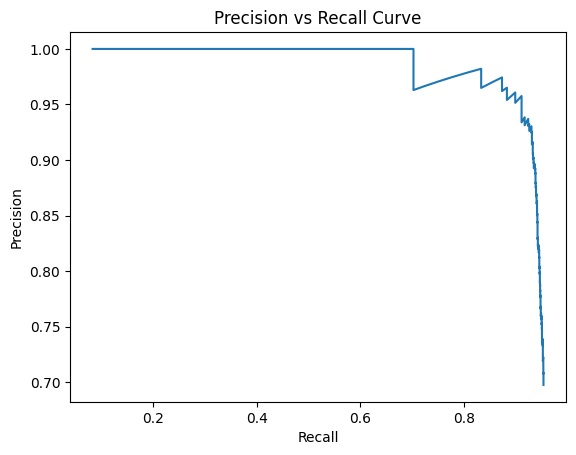

In [47]:
plt.plot(final_df_sort['recall'], final_df_sort['precision'])
plt.title('Precision vs Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

In [48]:
auc

tensor(0.8588, dtype=torch.float64)

In [49]:
os.getcwd()

'C:\\Users\\endo\\Desktop\\Yolov7-training-main\\Yolov7-training-main\\examples'

In [50]:
final_df_sort[['image_id', 'tp_fp_fn']]

,image_id,tp_fp_fn
0,226376,TP
1,227132,TP
2,226372,TP
3,226653,TP
4,227279,TP
...,...,...
338,226973,FN
339,226863,FP
340,226614,FN
341,243879,TN


In [51]:
TP = len(final_df_sort[final_df_sort['tp_fp_fn'] == 'TP'])
FP = len(final_df_sort[final_df_sort['tp_fp_fn'] == 'FP'])
FN = len(final_df_sort[final_df_sort['tp_fp_fn'] == 'FN'])
TN = len(final_df_sort[final_df_sort['tp_fp_fn'] == 'TN'])


In [52]:
confusion_matrix = np.array([[TP, FP], [FN, TN]])
confusion_matrix

array([[226,  98],
       [ 11,   8]])

## mAP using: COCOMeanAveragePrecision() object

In [53]:
# # Assuming you have loaded the test dataset and the trained model
# test_loader = ...
# model = ...

# # Evaluate the model on the test data
# predictions = []
# targets = []
# for batch in test_loader:
#     inputs = batch["image"]
#     targets.append(batch["targets"])
#     with torch.no_grad():
#         outputs = model(inputs)
#     predictions.append(outputs)

# # Concatenate the predictions and targets
# predictions = torch.cat(predictions)
# targets = torch.cat(targets)

# # Convert the predictions and targets to dataframes
# preds_df = pd.DataFrame(
#     predictions.cpu().numpy(),
#     columns=[
#         "xmin",
#         "ymin",
#         "xmax",
#         "ymax",
#         "score",
#         "class_id",
#         "image_id",
#     ],
# )
# targets_df = pd.DataFrame(
#     targets.cpu().numpy(),
#     columns=["image_id", "xmin", "ymin", "xmax", "ymax", "class_id"],
# )

# # Compute the mAP using COCOMeanAveragePrecision
# evaluator = COCOMeanAveragePrecision()
# map_ = evaluator.compute(targets_df, preds_df)

# print(f"mAP: {map_}")


TypeError: 'ellipsis' object is not iterable